In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
DATA_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [33]:
SAVE_MODEL = True

MODEL_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
MODEL_FILE_NAME = 'rf_tfidf_model.sav'

In [4]:
df = pd.read_csv(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\datanews_dataset_pre_processed.csv", 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [5]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [6]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [7]:
y = df.label
X = df.drop('label', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [9]:
X_train.shape

(30910, 4)

In [10]:
X_test.shape

(7728, 4)

In [11]:
le = LabelEncoder()

In [12]:
y_train_enc = le.fit_transform(y_train)

In [13]:
y_test_enc = le.transform(y_test)


In [14]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

In [17]:
# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\gist_stopwords.txt")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [18]:
expanded_stopwords.remove('via')

In [19]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

In [20]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_20016/1450276812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_20016/1450276812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.97      0.97      0.97     13957
        true       0.97      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



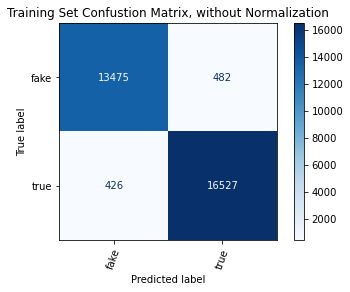

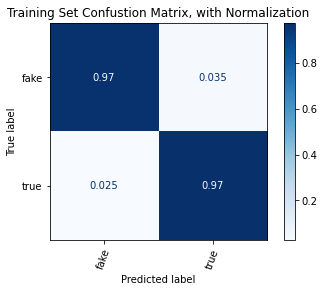

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      3490
        true       0.94      0.96      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.95      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



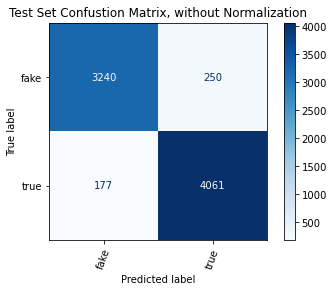

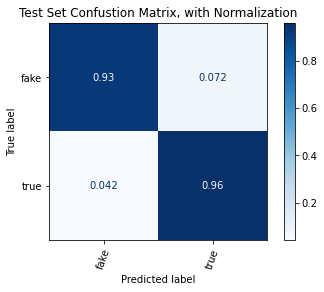

In [22]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)


In [23]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

,importance
said,0.176569
on,0.063491
you,0.046638
just,0.041934
this,0.031555
here,0.029729
in,0.026031
is,0.024914
like,0.022202
didn,0.018394


In [34]:
try: 
    os.mkdir(MODEL_PATH)
except FileExistsError:
    print('Model directory already exists')
    pass

Model directory already exists


In [35]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))